# Telecom Churn - ML Group Case Study
-  Predict churn only on high-value customers
-  Predict usage-based definition to define churn
-  This project is based on the Indian and Southeast Asian market
-  Churn Phases
    -  In ‘good’ phase the customer is happy with the service and behaves as usual
    -  In ‘action’ phase The customer experience starts to sore in this phase
    -  In ‘churn’ phase the customer is said to have churned


In [0]:
#Import Libraries
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import os # accessing directory structure


%matplotlib inline
pd.options.display.float_format = '{:.2f}'.format

import warnings
warnings.filterwarnings('ignore')

In [0]:
#The following commented code is used to get the telecom_churn_data.csv from the drive because we were working in Google Colab.

#Import Libraries to authenticate Google Drive and to get the dataset from the drive.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)


In [0]:
# The telecom churn dataset is present in the following Google Drive Link
# link = "https://drive.google.com/open?id=1iYXBP71rLFzO1gPwtBe4ixoHIjFFo7Ry"
# fluff, id = link.split('=')
# print(id)

In [0]:
# downloaded = drive.CreateFile({'id':id}) 
# downloaded.GetContentFile('telecom_churn_data.csv') 
df_tele_churn = pd.read_csv('telecom_churn_data.csv')

In [102]:
#Let's check the first five information
df_tele_churn.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,onnet_mou_8,onnet_mou_9,offnet_mou_6,offnet_mou_7,offnet_mou_8,offnet_mou_9,roam_ic_mou_6,roam_ic_mou_7,roam_ic_mou_8,roam_ic_mou_9,roam_og_mou_6,roam_og_mou_7,roam_og_mou_8,roam_og_mou_9,loc_og_t2t_mou_6,loc_og_t2t_mou_7,loc_og_t2t_mou_8,loc_og_t2t_mou_9,loc_og_t2m_mou_6,loc_og_t2m_mou_7,loc_og_t2m_mou_8,loc_og_t2m_mou_9,loc_og_t2f_mou_6,loc_og_t2f_mou_7,loc_og_t2f_mou_8,...,vol_3g_mb_7,vol_3g_mb_8,vol_3g_mb_9,arpu_3g_6,arpu_3g_7,arpu_3g_8,arpu_3g_9,arpu_2g_6,arpu_2g_7,arpu_2g_8,arpu_2g_9,night_pck_user_6,night_pck_user_7,night_pck_user_8,night_pck_user_9,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_2g_9,sachet_2g_6,sachet_2g_7,sachet_2g_8,sachet_2g_9,monthly_3g_6,monthly_3g_7,monthly_3g_8,monthly_3g_9,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,214.82,213.80,21.10,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,...,150.76,109.61,0.00,212.17,212.17,212.17,nan,212.17,212.17,212.17,nan,0.00,0.00,0.00,nan,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,1.00,1.00,1.00,nan,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,355.07,268.32,86.28,24.11,78.68,7.68,18.34,15.74,99.84,304.76,53.76,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,23.88,74.56,7.68,18.34,11.51,75.94,291.86,53.76,0.00,0.00,0.00,...,0.00,0.00,0.00,nan,0.00,0.00,nan,nan,28.61,7.60,nan,nan,0.00,0.00,nan,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,nan,1.00,1.00,nan,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,189.06,210.23,290.71,11.54,55.24,37.26,74.81,143.33,220.59,208.36,118.91,0.00,0.00,0.00,38.49,0.00,0.00,0.00,70.94,7.19,28.74,13.58,14.39,29.34,16.86,38.46,28.16,24.11,21.79,15.61,...,0.00,0.00,8.42,nan,nan,nan,2.84,nan,nan,nan,0.00,nan,nan,nan,0.00,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,nan,nan,nan,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,251.10,508.05,389.50,99.91,54.39,310.98,241.71,123.31,109.01,71.68,113.54,0.00,54.86,44.38,0.00,0.00,28.09,39.04,0.00,73.68,34.81,10.61,15.49,107.43,83.21,22.46,65.46,1.91,0.65,4.91,...,0.00,0.00,0.00,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,nan,nan,nan,nan,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,309.88,238.17,163.43,50.31,149.44,83.89,58.78,76.96,91.88,124.26,45.81,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,50.31,149.44,83.89,58.78,67.64,91.88,124.26,37.89,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,nan,nan,nan,0.00,nan,nan,nan,0.00,nan,nan,nan,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.00,nan,nan,nan,1526,0.00,0.00,0.00,0.00


In [103]:
#Let's check the shape of the dataset
print(df_tele_churn.shape)

(99999, 226)


### Filter High Value Customer

In [104]:
#Find columns with recharge info
#The total recharge amount is to be used for High Value Customer Filter
tot_rech_cols = [col for col in df_tele_churn.columns if 'total_rech_' in col]
print(tot_rech_cols)

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'total_rech_data_6', 'total_rech_data_7', 'total_rech_data_8', 'total_rech_data_9']


In [0]:
#Derive Total Data Recharge Amounts
df_tele_churn["total_rech_data_amt_6"] = df_tele_churn["total_rech_data_6"]  * df_tele_churn['av_rech_amt_data_6']
df_tele_churn["total_rech_data_amt_7"] = df_tele_churn["total_rech_data_7"]  * df_tele_churn['av_rech_amt_data_7']
df_tele_churn["total_rech_data_amt_8"] = df_tele_churn["total_rech_data_8"]  * df_tele_churn['av_rech_amt_data_8']
df_tele_churn["total_rech_data_amt_9"] = df_tele_churn["total_rech_data_9"]  * df_tele_churn['av_rech_amt_data_9']

In [0]:
# Drop total_rech_data_* and av_rech_amt_data_*
drop_col = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", 
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
df_tele_churn.drop(drop_col, axis=1, inplace=True)

In [107]:
#Average of Recharge Amount in 6th and 7th Month
av_rech_amt_6n7 = (df_tele_churn["total_rech_amt_6"].fillna(0) + df_tele_churn["total_rech_data_amt_6"].fillna(0) + 
df_tele_churn["total_rech_amt_7"].fillna(0) + df_tele_churn["total_rech_data_amt_7"].fillna(0))/2.0

#70th Percentile of Avg Recharge Amount
pc70_6n7 = np.percentile(av_rech_amt_6n7, 70.0)
print('70 percentile of 6th and 7th months avg recharge amount: ', pc70_6n7)

df_high_val_cust = df_tele_churn[av_rech_amt_6n7 >= pc70_6n7]
print('Dataframe Shape after Filtering HIgh Value Customers: ', df_high_val_cust.shape)

70 percentile of 6th and 7th months avg recharge amount:  478.0
Dataframe Shape after Filtering HIgh Value Customers:  (30001, 222)


### Data Cleaning & EDA

In [108]:
#List of columns with only 1 unqiue value
col_list = df_high_val_cust.loc[:,df_high_val_cust.apply(pd.Series.nunique) == 1]
col_list.head(5)


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9
0,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,nan,nan,0.00,nan,nan,nan,0.00,nan
7,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,nan,0.00,0.00,0.00,nan
8,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
21,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [109]:
#Remove Columns with only 1 unique value
df_high_val_cust = df_high_val_cust.loc[:,df_high_val_cust.apply(pd.Series.nunique) != 1]
df_high_val_cust.shape


(30001, 206)

#### Covert Column Names to meaningfull names

In [0]:
#Rename Columns with Meaning full Names

df_high_val_cust.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

#### Check Columns that can be changed to integers, floats or other types

In [111]:
#Check for Columns that can be changed to integers, floats or other types
object_col_data = df_high_val_cust.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_6    6/21/2014
date_of_last_rech_data_7    7/16/2014
date_of_last_rech_data_8     8/8/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [112]:
#Convert the object datatype to datetime datatype
for col in object_col_data.columns:
    df_high_val_cust[col] = pd.to_datetime(df_high_val_cust[col])

df_high_val_cust.shape

(30001, 206)

#### Drop Columns with > 30% of missing values

In [113]:
#Drop Columns with > 30% of missing values and excluding the september Month
columns = df_high_val_cust.columns
percent_missing = df_high_val_cust.isnull().sum() * 100 / len(df_high_val_cust)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

drop_col = missing_value_df.loc[(missing_value_df["column_name"].str.contains('_9')==False) & (missing_value_df["percent_missing"] > 30.0)]["column_name"]
drop_col

date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6                    night_pck_

In [114]:
#Drop the columns which has missing values > 30%
df_high_val_cust.drop(drop_col, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 179)

In [115]:
#Drop Rows with all Null Values
df_high_val_cust = df_high_val_cust.dropna(how='all',axis=0) 
df_high_val_cust.shape

(30001, 179)

#### Drop Highly Correlated Columns

In [116]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = df_high_val_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6        vol_3g_mb_6        0.60
total_ic_mou_7      loc_ic_t2t_mou_7   0.60
arpu_2g_9           count_rech_3g_9    0.60
total_og_mou_8      onnet_mou_9        0.60
total_rech_amt_8    arpu_6             0.60
roam_og_mou_8       roam_og_mou_7      0.60
offnet_mou_8        offnet_mou_6       0.60
total_ic_mou_8      loc_ic_t2t_mou_8   0.61
std_ic_mou_6        std_ic_t2m_mou_7   0.61
std_og_mou_9        std_og_t2m_mou_8   0.61
arpu_2g_9           vol_3g_mb_8        0.61
std_ic_mou_7        std_ic_t2m_mou_8   0.61
loc_og_mou_6        loc_og_t2t_mou_7   0.61
vbc_3g_8            vol_3g_mb_8        0.61
std_og_mou_8        std_og_t2m_mou_9   0.61
std_og_mou_9        offnet_mou_9       0.61
total_rech_amt_8    total_rech_amt_6   0.61
total_og_mou_6      std_og_t2t_mou_6   0.61
total_rech_amt_6    arpu_8             0.61
std_og_mou_7        std_og_t2t_mou_8   0.61
roam_ic_mou_8       roam_ic_mou_7      0.61
monthly_3g_7        monthly_3g_6       0.61
last_day_rch_amt_7  max_rech_amt

In [117]:
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
df_high_val_cust.drop(drop_col_list, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 124)

### Tag Churners

In [118]:
df_high_val_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].head()

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00
8,34.91,142.18,0.00,0.00
21,252.61,1031.53,0.00,0.00
23,127.48,127.63,13.93,314.74


In [0]:
#Let's churned the customers (churn=1, else 0) 
df_high_val_cust['churn'] = np.where(df_high_val_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 
                                   1,
                                   0)

In [120]:
df_high_val_cust['churn'].head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int64

In [121]:
#Remove All september month related columns
drop_cols = [col for col in df_high_val_cust.columns if '_9' in col]
print(drop_cols)

df_high_val_cust.drop(drop_cols, axis=1, inplace=True)

df_high_val_cust.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9', 'total_rech_data_amt_9']


(30001, 87)

### Reduce the No of Columns by Creating New Meaningful Features

Create Features with Average of 6th & 7th Month Since it's a "Good" Phase and Keep the 8th month untouched as it's "Action" Phase, for now to see if it can give any additional insight

In [122]:
col_list = df_high_val_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (df_high_val_cust.shape)

for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    df_high_val_cust[avg_col_name] = (df_high_val_cust[col_6]  + df_high_val_cust[col_7])/ 2



(30001, 87)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2c_mou
loc_og_mou
std_og_t2f_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_mou
std_ic_t2t_mou
std_ic_t2f_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
max_rech_amt
last_day_rch_amt
vol_2g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g


In [123]:
print (df_high_val_cust.shape)

#Let's drop the columns
col_list = df_high_val_cust.filter(regex='_6|_7').columns

df_high_val_cust.drop(col_list, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 115)


(30001, 59)

In [124]:
df_high_val_cust.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,vol_2g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,aon,vbc_3g_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2c_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2f_mou_av67,avg_std_og_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2f_mou_av67,avg_std_ic_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,5.75,0,0,1,0,968,30.40,1,206.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60
7,7000701601,3171.48,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.00,188.04,30.39,22.21,193.94,0.00,31.59,15.14,7,1580,779,0.00,0,0,0,0,802,57.74,1,1209.51,56.26,510.29,24.86,18.16,0.00,478.03,13.37,68.00,0.09,2.25,0.00,391.56,24.36,43.22,176.81,0.10,8.29,15.46,5.00,1185.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06
8,7001524846,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.00,15.79,0.10,0.00,0.75,0.00,0.00,0.00,14,30,10,0.03,0,3,0,0,315,21.03,0,435.47,382.36,87.64,0.00,0.00,0.00,333.13,0.00,136.87,0.00,0.00,0.00,52.63,0.29,0.00,13.54,0.00,0.00,0.00,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40
21,7002124215,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.00,159.11,0.18,0.00,101.93,0.00,0.00,0.00,27,50,50,0.00,0,0,0,0,720,0.00,0,556.10,117.26,827.30,0.00,0.00,0.00,95.56,0.00,848.99,0.00,0.00,0.00,106.50,10.02,0.00,62.98,0.00,0.00,0.00,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.00,224.21,13.38,0.00,57.29,0.00,3.74,13.06,4,179,0,0.01,0,0,1,1,604,40.45,0,134.12,49.81,87.38,0.00,0.00,0.00,132.80,0.00,4.35,0.01,0.05,0.00,145.52,0.26,0.00,8.92,0.00,14.12,2.67,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93


In [125]:
#Conevrt AON in Months
df_high_val_cust['aon_mon'] = df_high_val_cust['aon']/30
df_high_val_cust.drop('aon', axis=1, inplace=True)
df_high_val_cust['aon_mon'].head()

0    32.27
7    26.73
8    10.50
21   24.00
23   20.13
Name: aon_mon, dtype: float64

Text(0.5, 1.0, 'Churn Distribution')

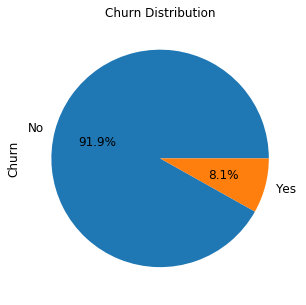

In [126]:
#Churn Distribution
ax = (df_high_val_cust['churn'].value_counts()*100.0 /len(df_high_val_cust)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           

ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)

In our data, 91% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

Distribution graphs (histogram/bar graph) of sampled columns:

Text(0.5, 1.0, 'Customers by their tenure')

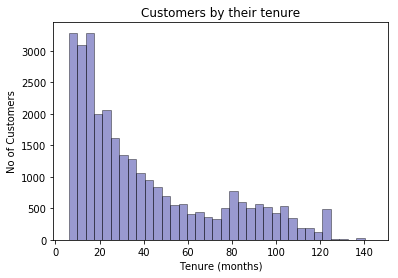

In [127]:
ax = sns.distplot(df_high_val_cust['aon_mon'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('No of Customers')
ax.set_xlabel('Tenure (months)')
ax.set_title('Customers by their tenure')

In [128]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
df_high_val_cust['tenure_range'] = pd.cut(df_high_val_cust['aon_mon'], tn_range, labels=tn_label)
df_high_val_cust['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

#### Correlation of "Churn" with other variables:


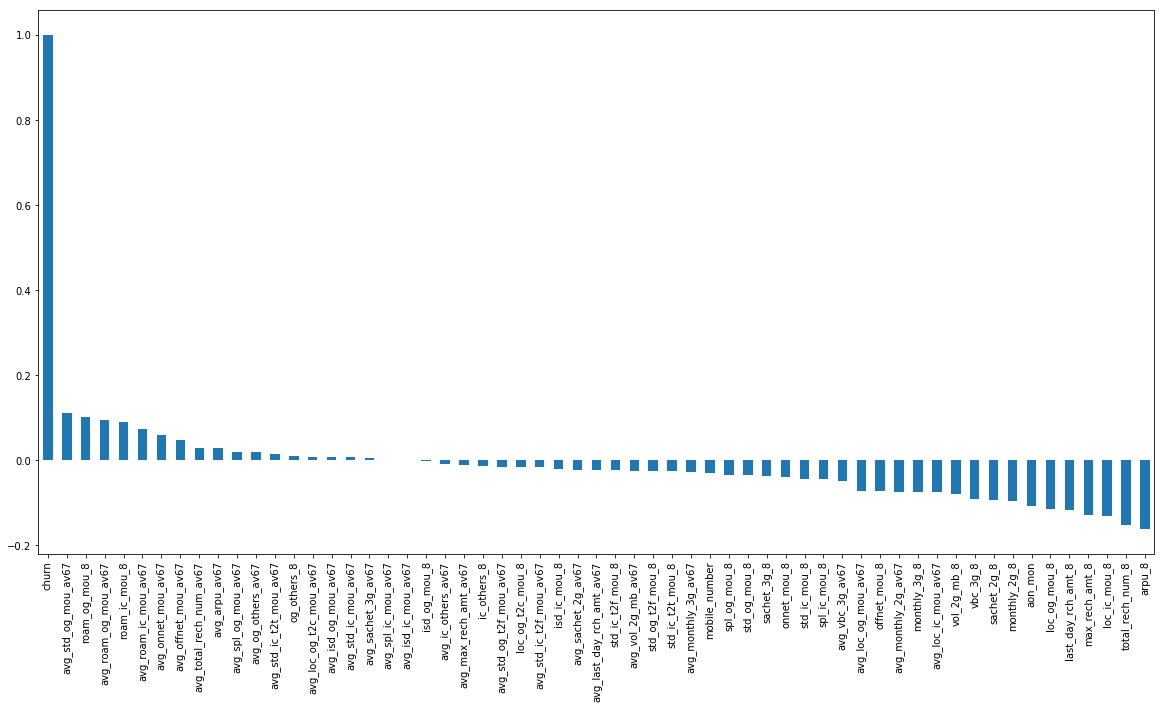

In [129]:
#Check the Correlation of "Churn" with other variables:
plt.figure(figsize=(20,10))
df_high_val_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

Avg STD Outgoing Calls for Month 6 & 7, Outgoing calls in Roaming seems to be positively correlated with Churn while Avg Revenue, No Of Recharge for 8th Month seems negatively correlated.

Lets look at the relation between total recharge in 8th Month Vs Average Revenue in 8th Month

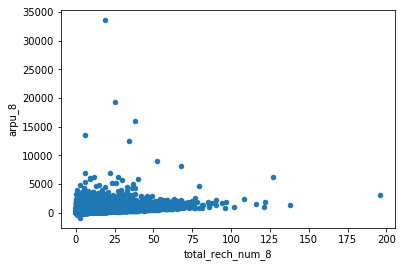

In [130]:
df_high_val_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')

Lets look at the relation between Tenure And Revenue

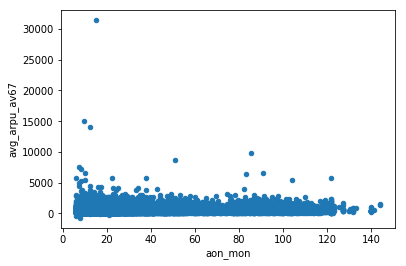

In [131]:
df_high_val_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',
                                                              y='avg_arpu_av67')

Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot.

#### Churn vs Tenure 

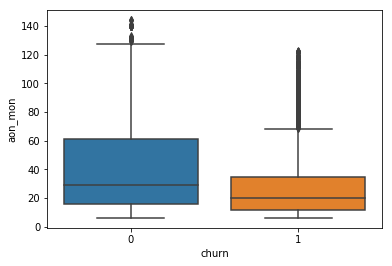

In [132]:
sns.boxplot(x = df_high_val_cust.churn, y = df_high_val_cust.aon_mon)


As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.

#### Churn Vs Volume based cost

Text(0.5, 1.0, 'Distribution of Volume based cost by churn')

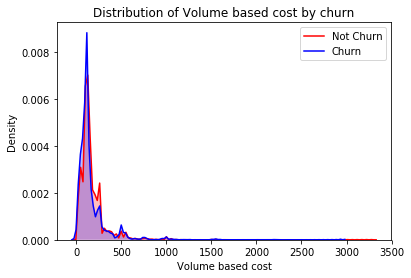

In [133]:
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Volume based cost by churn')

#### Churn Vs Max Recharge Amount

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

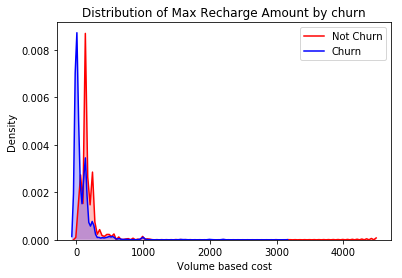

In [134]:
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

* People Who Recharge with less Amount are more likely to Churn
* There is no visible difference in Volume Based Cost & Churn

In [135]:
df_high_val_cust.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,vol_2g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,vbc_3g_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2c_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2f_mou_av67,avg_std_og_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2f_mou_av67,avg_std_ic_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,aon_mon,tenure_range
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,5.75,0,0,1,0,30.40,1,206.10,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60,32.27,2-5 Yrs
7,7000701601,3171.48,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.00,188.04,30.39,22.21,193.94,0.00,31.59,15.14,7,1580,779,0.00,0,0,0,0,57.74,1,1209.51,56.26,510.29,24.86,18.16,0.00,478.03,13.37,68.00,0.09,2.25,0.00,391.56,24.36,43.22,176.81,0.10,8.29,15.46,5.00,1185.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,26.73,2-5 Yrs
8,7001524846,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.00,15.79,0.10,0.00,0.75,0.00,0.00,0.00,14,30,10,0.03,0,3,0,0,21.03,0,435.47,382.36,87.64,0.00,0.00,0.00,333.13,0.00,136.87,0.00,0.00,0.00,52.63,0.29,0.00,13.54,0.00,0.00,0.00,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40,10.50,6-12 Months
21,7002124215,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.00,159.11,0.18,0.00,101.93,0.00,0.00,0.00,27,50,50,0.00,0,0,0,0,0.00,0,556.10,117.26,827.30,0.00,0.00,0.00,95.56,0.00,848.99,0.00,0.00,0.00,106.50,10.02,0.00,62.98,0.00,0.00,0.00,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00,1-2 Yrs
23,7000887461,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.00,224.21,13.38,0.00,57.29,0.00,3.74,13.06,4,179,0,0.01,0,0,1,1,40.45,0,134.12,49.81,87.38,0.00,0.00,0.00,132.80,0.00,4.35,0.01,0.05,0.00,145.52,0.26,0.00,8.92,0.00,14.12,2.67,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93,20.13,1-2 Yrs


In [136]:
#Lets Create New DF for Model Building

df_telecom_churn = df_high_val_cust[:].copy()

#Dropping tenure_range since we have AON MONTH already and columns are highly corelated
df_telecom_churn.drop('tenure_range', axis=1, inplace=True)
df_telecom_churn.drop('mobile_number', axis=1, inplace=True)

#Since All The Values are realted to Price/ Cost/ Amount, Filling NaN with 0

df_telecom_churn.fillna(0, inplace=True)

df_telecom_churn.head()

,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,isd_og_mou_8,spl_og_mou_8,og_others_8,loc_ic_mou_8,std_ic_t2t_mou_8,std_ic_t2f_mou_8,std_ic_mou_8,spl_ic_mou_8,isd_ic_mou_8,ic_others_8,total_rech_num_8,max_rech_amt_8,last_day_rch_amt_8,vol_2g_mb_8,monthly_2g_8,sachet_2g_8,monthly_3g_8,sachet_3g_8,vbc_3g_8,churn,avg_arpu_av67,avg_onnet_mou_av67,avg_offnet_mou_av67,avg_roam_ic_mou_av67,avg_roam_og_mou_av67,avg_loc_og_t2c_mou_av67,avg_loc_og_mou_av67,avg_std_og_t2f_mou_av67,avg_std_og_mou_av67,avg_isd_og_mou_av67,avg_spl_og_mou_av67,avg_og_others_av67,avg_loc_ic_mou_av67,avg_std_ic_t2t_mou_av67,avg_std_ic_t2f_mou_av67,avg_std_ic_mou_av67,avg_spl_ic_mou_av67,avg_isd_ic_mou_av67,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,aon_mon
0,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,5.44,0.00,0.00,0.00,0.00,0.00,0.00,2,252,252,5.75,0,0,1,0,30.40,1,206.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60,32.27
7,3171.48,52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,10.01,6.50,0.00,188.04,30.39,22.21,193.94,0.00,31.59,15.14,7,1580,779,0.00,0,0,0,0,57.74,1,1209.51,56.26,510.29,24.86,18.16,0.00,478.03,13.37,68.00,0.09,2.25,0.00,391.56,24.36,43.22,176.81,0.10,8.29,15.46,5.00,1185.00,0.00,0.00,0.00,0.00,0.00,0.00,19.06,26.73
8,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,0.00,10.23,0.00,15.79,0.10,0.00,0.75,0.00,0.00,0.00,14,30,10,0.03,0,3,0,0,21.03,0,435.47,382.36,87.64,0.00,0.00,0.00,333.13,0.00,136.87,0.00,0.00,0.00,52.63,0.29,0.00,13.54,0.00,0.00,0.00,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40,10.50
21,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,0.00,0.00,0.00,159.11,0.18,0.00,101.93,0.00,0.00,0.00,27,50,50,0.00,0,0,0,0,0.00,0,556.10,117.26,827.30,0.00,0.00,0.00,95.56,0.00,848.99,0.00,0.00,0.00,106.50,10.02,0.00,62.98,0.00,0.00,0.00,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00
23,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,0.00,17.71,0.00,224.21,13.38,0.00,57.29,0.00,3.74,13.06,4,179,0,0.01,0,0,1,1,40.45,0,134.12,49.81,87.38,0.00,0.00,0.00,132.80,0.00,4.35,0.01,0.05,0.00,145.52,0.26,0.00,8.92,0.00,14.12,2.67,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93,20.13


In [0]:
X = df_telecom_churn.drop(['churn'], axis=1)
y = df_telecom_churn['churn']

df_telecom_churn.drop('churn', axis=1, inplace=True)


In [0]:
#Let's perform the scaling on the data using StandardScaler
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler().fit(X)
X = scaler.transform(X)

In [0]:
# Split the dataset as train & test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

In [140]:
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data : ", y_train_imb)
print("Imbalance in Test Data : ", y_test_imb)

X_train Shape :  (21000, 57)
X_test Shape :  (9001, 57)
Imbalance in Train Data :  0.08875985068436333
Imbalance in Test Data :  0.08812862669245648


In [0]:
# Balancing DataSet
from imblearn.over_sampling import SMOTE

sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)

In [142]:
print("X_tr Shape", X_tr.shape)
print("y_tr Shape", y_tr.shape)

imb = (y_tr != 0).sum()/(y_tr == 0).sum()
print("Imbalance in Train Data : ",imb)

X_tr Shape (38576, 57)
y_tr Shape (38576,)
Imbalance in Train Data :  1.0


### Model Building

#### RFE

In [0]:
# Feature reduction using RFE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.feature_selection import RFE

# running RFE with 15 variables as output
rfe = RFE(lr, n_features_to_select=15)   
rfe = rfe.fit(X_tr, y_tr)

In [144]:
rfe_features = list(df_telecom_churn.columns[rfe.support_])
print("Features identified by RFE ", rfe_features)

Features identified by RFE  ['loc_og_mou_8', 'og_others_8', 'loc_ic_mou_8', 'std_ic_t2t_mou_8', 'std_ic_t2f_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'avg_arpu_av67', 'avg_loc_ic_mou_av67']


In [0]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

### Logistic Regression

In [146]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [147]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[6570 1702]
 [ 140  589]]


In [148]:
print('Accuracy of Logistic Regression Model on test set is ',round(lr.score(X_test_rfe, y_test), 2))

Accuracy of Logistic Regression Model on test set is  0.8


In [149]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.79      0.88      8272
           1       0.26      0.81      0.39       729

    accuracy                           0.80      9001
   macro avg       0.62      0.80      0.63      9001
weighted avg       0.92      0.80      0.84      9001



In [150]:
# To get the weights of all the variables
weights = pd.Series(lr.coef_[0],
                 index=rfe_features)
weights.sort_values(ascending = False)

avg_loc_ic_mou_av67    0.70
avg_arpu_av67          0.58
std_ic_t2t_mou_8      -0.23
std_ic_t2f_mou_8      -0.35
std_ic_mou_8          -0.35
vol_2g_mb_8           -0.38
spl_ic_mou_8          -0.40
monthly_3g_8          -0.48
last_day_rch_amt_8    -0.57
total_rech_num_8      -0.60
sachet_2g_8           -0.65
monthly_2g_8          -0.70
loc_og_mou_8          -1.13
loc_ic_mou_8          -2.63
og_others_8           -2.67
dtype: float64

LR Summary
* Model Accuracy is 80%
* Confusion matix clearly shows that the model has drawback in predicting churn as high false positives.

#### PCA

In [151]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

#Applying Smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)


(38576, 57)
(38576,)


Applying  PCA

In [152]:
#Importing the PCA module
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

#Doing the PCA on the train data
pca.fit(X_tr)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=100,
    svd_solver='auto', tol=0.0, whiten=False)

In [153]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(38576, 57)
(9001, 57)


Applying logistic regression


In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# Predicted probabilities
y_pred = lr_pca.predict(X_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [155]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[6752 1520]
 [ 129  600]]


In [156]:
print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred))

Logistic Regression accuracy with PCA:  0.8167981335407177


In [157]:
col = list(df_telecom_churn.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

,PC1,PC2,PC3,Feature
0,0.25,-0.12,0.17,arpu_8
1,0.15,-0.20,-0.03,onnet_mou_8
2,0.21,-0.18,0.05,offnet_mou_8
3,0.34,0.33,-0.15,roam_ic_mou_8
4,0.26,0.18,-0.12,roam_og_mou_8
5,0.04,-0.06,-0.01,loc_og_t2c_mou_8
6,0.11,-0.11,0.18,loc_og_mou_8
7,0.03,-0.00,0.08,std_og_t2f_mou_8
8,0.17,-0.25,-0.07,std_og_mou_8
9,0.03,-0.01,0.04,isd_og_mou_8


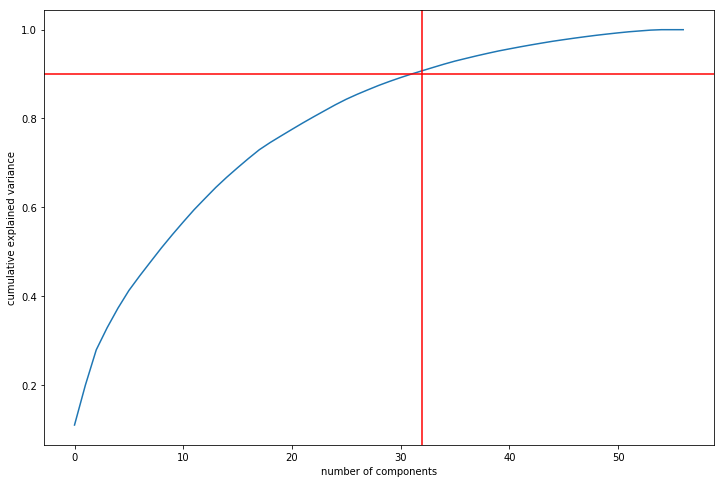

In [158]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.axvline(x=32, c = 'red')
plt.axhline(y = 0.9, c = 'red')
plt.show()

In [159]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.92,  19.91,  27.86,  32.84,  37.27,  41.23,  44.55,  47.72,
        50.86,  53.83,  56.68,  59.45,  61.98,  64.48,  66.76,  68.91,
        70.99,  72.97,  74.59,  76.08,  77.55,  79.  ,  80.39,  81.75,
        83.1 ,  84.34,  85.45,  86.48,  87.47,  88.38,  89.23,  90.03,
        90.78,  91.52,  92.26,  92.94,  93.54,  94.13,  94.68,  95.21,
        95.68,  96.14,  96.58,  97.  ,  97.4 ,  97.76,  98.11,  98.44,
        98.75,  99.03,  99.29,  99.53,  99.72,  99.9 , 100.  , 100.  ,
       100.  ])

Applying LR with 32 columns with 90% variance


In [160]:
pca_32 = PCA(n_components=32)

df_tr_pca_32 = pca_32.fit_transform(X_tr)
print(df_tr_pca_32.shape)

df_test_pca_32 = pca_32.transform(X_test)
print(df_test_pca_32.shape)

(38576, 32)
(9001, 32)


In [0]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_32, y_tr)

# Predicted probabilities
y_pred32 = lr_pca1.predict(df_test_pca_32)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred32)

In [162]:
print(confusion_matrix(y_test,y_pred32))

[[6714 1558]
 [ 144  585]]


In [163]:
print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred32))

Logistic Regression accuracy with PCA:  0.8109098989001222


PCA Summary :
*  Model has 81% Accuracy
* 32 Features can obtain optimal accuracy with 90% Variance
* Main Features are arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8

#### Decision Tress

In [164]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

#Applying Smote
from imblearn.over_sampling import SMOTE
sm = SMOTE(kind = "regular")
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38576, 57)
(38576,)


Feature reduction using LASSO


In [165]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
model = SelectFromModel(lsvc, prefit=True)
X_lasso = model.transform(X_tr)
pos = model.get_support(indices=True)
 ### Feature reduction using RFE
print(X_lasso.shape)
print(pos)

(38576, 31)
[ 0  2  3  4  6  7  8 10 12 15 16 19 20 21 22 23 24 25 26 27 28 31 33 36
 40 43 47 48 50 51 56]


In [166]:
#feature vector for decision tree
lasso_features = list(df_telecom_churn.columns[pos])
print("Features for LASSO model buidling: ", lasso_features)

Features for LASSO model buidling:  ['arpu_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'vbc_3g_8', 'avg_arpu_av67', 'avg_roam_ic_mou_av67', 'avg_loc_og_t2c_mou_av67', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'avg_std_ic_mou_av67', 'avg_total_rech_num_av67', 'avg_max_rech_amt_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'aon_mon']


Decision Tree with Default Hyperparameter

In [167]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [168]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
X_test = pd.DataFrame(data=X_test).iloc[:, pos]
y_pred1 = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.88      0.93      8272
           1       0.36      0.76      0.49       729

    accuracy                           0.87      9001
   macro avg       0.67      0.82      0.71      9001
weighted avg       0.93      0.87      0.89      9001



In [169]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred1))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred1))

[[7281  991]
 [ 173  556]]
Accuracy of Decision Tree : 0.8706810354405066


#### Hyperparameter Tuning
Tuning max_depth

In [170]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dt = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dt, parameters, 
                    cv=n_folds, 
                 scoring="accuracy", return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None, param_grid={'max_depth': range(1, 40)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring='

In [171]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.09,0.00,0.00,0.00,1,{'max_depth': 1},0.79,0.79,0.79,0.78,0.79,0.79,0.00,39,0.79,0.79,0.79,0.79,0.79,0.79,0.00
1,0.17,0.00,0.00,0.00,2,{'max_depth': 2},0.81,0.81,0.81,0.81,0.82,0.81,0.00,38,0.81,0.81,0.81,0.81,0.81,0.81,0.00
2,0.24,0.00,0.00,0.00,3,{'max_depth': 3},0.84,0.86,0.86,0.85,0.86,0.86,0.01,37,0.86,0.86,0.86,0.86,0.86,0.86,0.00
3,0.31,0.01,0.00,0.00,4,{'max_depth': 4},0.85,0.86,0.86,0.86,0.87,0.86,0.01,36,0.86,0.86,0.87,0.86,0.86,0.86,0.00
4,0.37,0.00,0.00,0.00,5,{'max_depth': 5},0.86,0.88,0.88,0.87,0.88,0.87,0.01,35,0.88,0.88,0.88,0.88,0.88,0.88,0.00


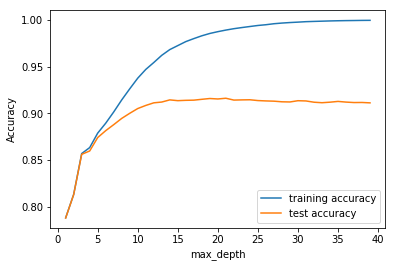

In [172]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

According to above plot, max_depth =10 is optimal

Tuning min_samples_leaf

In [173]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tru

In [174]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.05,0.04,0.00,0.00,5,{'min_samples_leaf': 5},0.88,0.91,0.91,0.91,0.91,0.91,0.01,1,0.97,0.96,0.96,0.97,0.96,0.97,0.00
1,0.89,0.05,0.00,0.00,25,{'min_samples_leaf': 25},0.87,0.90,0.90,0.89,0.90,0.89,0.01,2,0.92,0.92,0.92,0.92,0.92,0.92,0.00
2,0.77,0.03,0.00,0.00,45,{'min_samples_leaf': 45},0.87,0.89,0.90,0.89,0.90,0.89,0.01,3,0.91,0.91,0.91,0.90,0.90,0.91,0.00
3,0.71,0.02,0.00,0.00,65,{'min_samples_leaf': 65},0.87,0.89,0.89,0.89,0.89,0.89,0.01,4,0.90,0.90,0.90,0.90,0.90,0.90,0.00
4,0.67,0.02,0.00,0.00,85,{'min_samples_leaf': 85},0.87,0.89,0.88,0.89,0.89,0.88,0.01,5,0.90,0.89,0.89,0.89,0.89,0.89,0.00


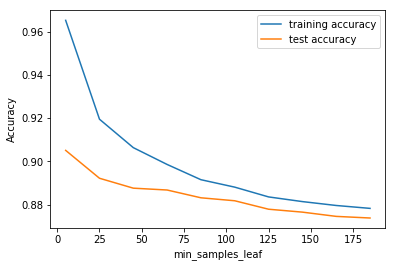

In [175]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf = 25 looks to be optimal

Tuning min_samples_split

In [176]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=100,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'min_samples_split': range(5, 200, 20)},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=Tr

In [177]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.15,0.06,0.00,0.00,5,{'min_samples_split': 5},0.88,0.92,0.92,0.92,0.92,0.91,0.02,1,0.99,0.99,0.99,0.99,0.99,0.99,0.00
1,1.09,0.06,0.00,0.00,25,{'min_samples_split': 25},0.87,0.91,0.91,0.91,0.91,0.90,0.01,2,0.96,0.96,0.96,0.96,0.96,0.96,0.00
2,1.12,0.06,0.00,0.00,45,{'min_samples_split': 45},0.87,0.90,0.90,0.90,0.91,0.90,0.01,3,0.95,0.94,0.94,0.94,0.94,0.94,0.00
3,1.08,0.07,0.00,0.00,65,{'min_samples_split': 65},0.86,0.90,0.90,0.90,0.91,0.90,0.02,4,0.94,0.93,0.93,0.93,0.93,0.93,0.00
4,1.11,0.05,0.00,0.00,85,{'min_samples_split': 85},0.87,0.90,0.90,0.90,0.91,0.89,0.01,5,0.93,0.93,0.92,0.93,0.92,0.93,0.00


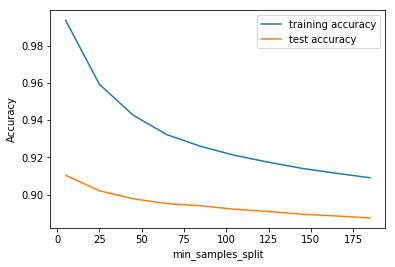

In [178]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf=50 looks optimal

In [179]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1, return_train_score=True)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  1.2min finished


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                      

In [180]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)


Best Accuracy 0.892964537536292


In [181]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')


In [182]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=25, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=100, splitter='best')

In [183]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.8714587268081324


#### Summary - Decision Tress
* Getting around 87% accuracy 
* Confusion matix shows lot of false positives still exist.
* 31 Features were selected for Model Building

### Random Forest

Random Forest with Default Hyperparameters

In [184]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, prediction_test))

Randon Forest Accuracy with Default Hyperparameter 0.9227863570714365


In [185]:
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8272
           1       0.52      0.63      0.57       729

    accuracy                           0.92      9001
   macro avg       0.74      0.79      0.76      9001
weighted avg       0.93      0.92      0.93      9001



In [186]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[7849  423]
 [ 272  457]]


#### Hyperparameter Tuning

Tuning max_depth

In [187]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [188]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.24,0.00,0.01,0.00,2,{'max_depth': 2},0.84,0.85,0.82,0.81,0.81,0.83,0.02,4,0.86,0.85,0.82,0.81,0.81,0.83,0.02
1,0.60,0.02,0.01,0.00,7,{'max_depth': 7},0.88,0.90,0.90,0.90,0.90,0.90,0.01,3,0.91,0.91,0.91,0.91,0.90,0.91,0.00
2,0.88,0.03,0.01,0.00,12,{'max_depth': 12},0.92,0.93,0.94,0.93,0.94,0.93,0.01,2,0.97,0.96,0.96,0.96,0.96,0.96,0.00
3,1.03,0.01,0.01,0.00,17,{'max_depth': 17},0.93,0.95,0.95,0.95,0.95,0.95,0.01,1,0.99,0.99,0.98,0.99,0.98,0.99,0.00


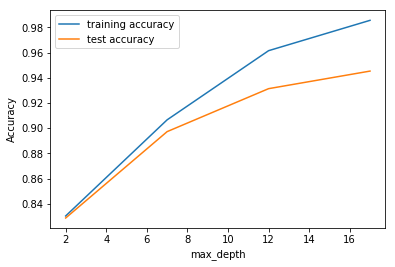

In [189]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Tuning min_samples_leaf

In [190]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

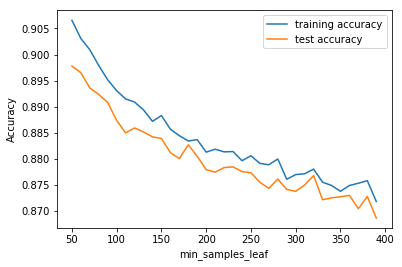

In [191]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Tuning min_samples_split

In [192]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

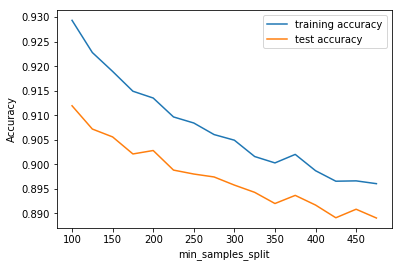

In [193]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Grid Search to Find Optimal Hyperparameters

In [0]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1, return_train_score=True)

In [0]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [196]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5493
           1       0.73      0.41      0.52       508

    accuracy                           0.94      6001
   macro avg       0.84      0.70      0.75      6001
weighted avg       0.93      0.94      0.93      6001

[[5415   78]
 [ 300  208]]


In [197]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

Accuracy Score for Random Forest Final Model : 0.9370104982502916


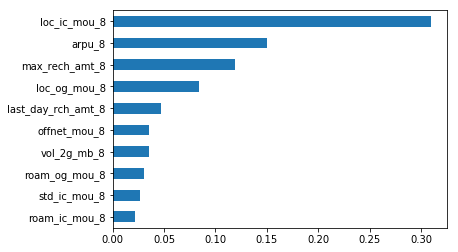

In [198]:
X = df_telecom_churn
# Scaling all the variables to a range of 0 to 1
#from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

Observations:

* From random forest algorithm, Local Incoming for Month 8, Average Revenue Per Customer for Month 8 and Max Recharge Amount for Month 8 are the most important predictor variables to predict churn.
* The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

### Summary:
* Very Less Amount of High Value customers are churning which is a good service indicator
* Large no of Customers are new to Telecom Company and fall under < 5 Yr Tenure
* Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn
* People with less than 4 Yrs of Tenure are more likely to Churn
* Behaviour of Volume Based Cost is not a strong indicator of Churn
* Max Recharge Amount could be a good Churn Indicator
* Random Forest is the best method to Predict Churn followed by SVM, other models too do a fair job
* Behaviour is 8 Month can be the base of Churn Analysis
* Local Incoming and Outgoing Calls for 8th Month and Average Revenue in 8th Month are strong indicators of Churn Behaviour